In [ ]:
from builtins import range, input
import os
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve,accuracy_score,classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

from pathlib import Path
from imutils import paths

In [ ]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
# epochs =
batch_size = 64

#define paths
from google.colab import drive
drive.mount('/content/drive')
path_train="/content/drive/MyDrive/datasets/train"
# path_val = "/content/drive/MyDrive/datasets/val"

Normalimages = os.listdir(path_train + "/Normal")
COVID19images = os.listdir(path_train + "/Covid")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Total Count: ",len(Normalimages))
print("Total Count: ",len(COVID19images))

Total Count:  367
Total Count:  319


In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
trainPaths = list(paths.list_images(path_train))
# valPaths = list(paths.list_images(path_val))

In [ ]:
print(len(trainPaths))
# print(len(valPaths))

686


In [ ]:
trainPaths[2].split(os.path.sep)[-2]

'Normal'

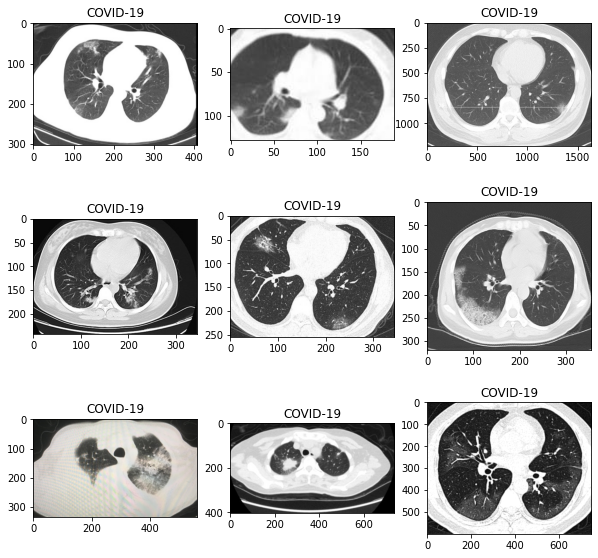

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(path_train + "/Covid",COVID19images[i])),cmap='gray')
    plt.title("COVID-19")
plt.show()

In [ ]:
trainData = []
trainLabels = []

# loop over the image paths
for img in trainPaths:
# extract the class label from the filename
    label = img.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    #preprocess image by converting to RGB channel ordering, and resizing it to 224×224 pixels
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    trainData.append(image)
    trainLabels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
trainData = np.array(trainData) / 255.0
trainLabels = np.array(trainLabels)

In [ ]:
# valData = []
# valLabels = []

# # loop over the image paths
# for img in valPaths:
# # extract the class label from the filename
#     label = img.split(os.path.sep)[-2]
#     # load the image, swap color channels, and resize it to be a fixed
#     # 224x224 pixels while ignoring aspect ratio
#     #preprocess image by converting to RGB channel ordering, and resizing it to 224×224 pixels
#     image = cv2.imread(img)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = cv2.resize(image, (224, 224))
#     # update the data and labels lists, respectively
#     valData.append(image)
#     valLabels.append(label)
# # convert the data and labels to NumPy arrays while scaling the pixel
# # intensities to the range [0, 1]
# valData = np.array(valData) / 255.0
# valLabels = np.array(valLabels)

In [ ]:
len(trainData),len(trainLabels)

(686, 686)

In [ ]:
# perform one-hot encoding on the train labels
lb = LabelBinarizer()
trainLabels = lb.fit_transform(trainLabels)
trainLabels = to_categorical(trainLabels)

In [ ]:

# perform one-hot encoding on the test labels
# valLabels = lb.fit_transform(valLabels)
# valLabels = to_categorical(valLabels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(x_train, x_val, y_train, y_val) = train_test_split(trainData, trainLabels, test_size=0.30, stratify=trainLabels, random_state=28)
# initialize the training data augmentation object
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [ ]:
# Building Model
from tensorflow.keras.applications import Xception
xception = Xception(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = xception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=xception.input, outputs=outputs)

for layer in xception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)
model.summary()


83697664/83683744 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                      

In [ ]:
# # Building Model
# resnet = ResNet50(weights="imagenet", include_top=False,
#     input_tensor=Input(shape=(224, 224, 3)))

# outputs = resnet.output
# outputs = Flatten(name="flatten")(outputs)
# outputs = Dropout(0.5)(outputs)
# outputs = Dense(2, activation="softmax")(outputs)

# model = Model(inputs=resnet.input, outputs=outputs)

# for layer in resnet.layers:
#     layer.trainable = False

# model.compile(
#         loss='categorical_crossentropy',
#         optimizer='adam', 
#         metrics=['accuracy']
# )
# model.summary()

In [ ]:
history = model.fit(train_aug.flow(x_train, y_train, batch_size=60),
                    validation_data=(x_val, y_val),
                    validation_steps=len(x_val) / 60,
                    steps_per_epoch=len(x_train) / 60,
                    epochs=10)

Epoch 1/10
8/8 [==============================] - 19s 2s/step - loss: 0.5196 - accuracy: 0.8750 - val_loss: 0.9608 - val_accuracy: 0.8058
Epoch 2/10
8/8 [==============================] - 9s 1s/step - loss: 0.4263 - accuracy: 0.9021 - val_loss: 1.2334 - val_accuracy: 0.8204
Epoch 3/10
8/8 [==============================] - 9s 1s/step - loss: 0.5517 - accuracy: 0.8875 - val_loss: 0.9727 - val_accuracy: 0.8107
Epoch 4/10
8/8 [==============================] - 9s 1s/step - loss: 0.4742 - accuracy: 0.8896 - val_loss: 1.0043 - val_accuracy: 0.8204
Epoch 5/10
8/8 [==============================] - 9s 1s/step - loss: 0.6810 - accuracy: 0.8604 - val_loss: 0.8558 - val_accuracy: 0.8155
Epoch 6/10
8/8 [==============================] - 9s 1s/step - loss: 0.4228 - accuracy: 0.8958 - val_loss: 0.9211 - val_accuracy: 0.8010
Epoch 7/10
8/8 [==============================] - 9s 1s/step - loss: 0.4826 - accuracy: 0.8833 - val_loss: 0.9274 - val_accuracy: 0.7767
Epoch 8/10
8/8 [========================

In [ ]:
# Save Model and Weights
model.save('/content/drive/MyDrive/resnet_ct.h5')
model.save_weights('/content/drive/MyDrive/resnet_weights_ct.hdf5')

In [ ]:
# Load saved model
model1 = load_model('/content/drive/MyDrive/resnet_ct.h5')

In [ ]:
y_pred = model.predict(x_train,batch_size=60)

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_train, axis=1)

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin,y_pred_bin))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       223
           1       0.95      0.91      0.93       257

    accuracy                           0.93       480
   macro avg       0.92      0.93      0.92       480
weighted avg       0.93      0.93      0.93       480



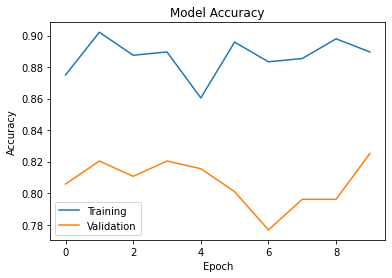

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Validation'])
plt.show()


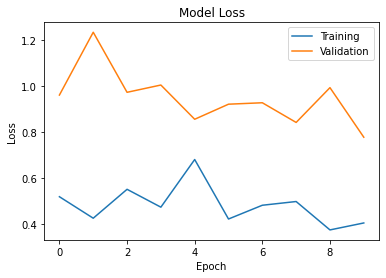

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Validation'])
plt.show()

In [ ]:
import tensorflow as tf
def detect(img):
  pimage = cv2.imread(img)
  # pimage = cv2.cvtColor(pimage, cv2.COLOR_BGR2RGB)
  # pimage=tf.io.color.bgr_to_rgb(pimage)
  pimage = pimage[...,::-1]
  pimage = cv2.resize(pimage, (224, 224))
  pimgdata = np.array(pimage) / 255.0
  image_batch = np.expand_dims(pimgdata,axis=0)
  pred_new= model1.predict(image_batch)
  pred_new= np.argmax(pred_new, axis=1)
  if pred_new==1:
      print("NORMAL")
  else:
      print("COVID-19")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
imgpath = '/content/normal.jpeg'
detect(imgpath)